# Visualization of multi-modal representations

In [1]:
from data.datamodule import QuestionEvaluationDataModule, CLaMPDataModule
from model.clamp import CLaMPLite
import argparse
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import umap
import matplotlib.pyplot as plt

## Load dataset and model

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--data-path', type=str, default='/home/yj/PycharmProjects/MIT/CLaMP/jsons/mp_3d_2020_materials_graphs_gpt_questions')
# parser.add_argument('--data-path', type=str, default='/home/yj/PycharmProjects/MIT/CLaMP/jsons/mp_3d_2020_nuclear_questions_0')
# parser.add_argument('--data-path', type=str, default={
#     'train': '/home/yj/PycharmProjects/MIT/CLaMP/jsons/mp_3d_2020_materials_graphs_gpt_questions_train.parquet',
#     'val': '/home/yj/PycharmProjects/MIT/CLaMP/jsons/mp_3d_2020_materials_graphs_gpt_questions_val.parquet',
#     'test': '/home/yj/PycharmProjects/MIT/CLaMP/jsons/mp_3d_2020_materials_graphs_gpt_questions_test.parquet'
# })
parser.add_argument('--batch-size', type=int, default=64, help='1 for QA')  # 8, 64, 128, 512
parser.add_argument('--num-workers', type=int, default=12)
parser.add_argument('--llm', type=str, default='allenai/scibert_scivocab_cased')
# parser.add_argument('--llm', type=str, default='facebook/galactica-125m')
parser.add_argument('--debug', type=bool, default=False)
parser.add_argument('--label', type=str, default='structure_question_list', choices=['text', 'composition_question_list', 'structure_question_list', 'metal_question_list', 'semiconductor_question_list', 'stable_question_list', 'oxide_question_list', 'Statements'])
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-10-22/12-13-19/epoch=35-step=24768.ckpt')  # papers
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-10-21/03-47-05/epoch=9-step=1980.ckpt')  # GPT
parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-11/14-27-14/epoch=39-step=27520.ckpt')  # papers-painn
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-10/11-27-57/epoch=39-step=15800.ckpt')  # gpt-painn
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-09/00-24-38/epoch=38-step=15405.ckpt')  # gpt-painn-galax
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-11/04-24-47/epoch=7-step=3160.ckpt')  # gpt-cgcnn-galax
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-02/13-51-53/epoch=38-step=34515.ckpt')  # merged
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-11-19/11-05-21/epoch=87-step=77880.ckpt')  # merged - painn
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-12-01/09-27-24/epoch=9-step=1980.ckpt')  # crystal only
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-12-01/12-31-20/epoch=19-step=17700.ckpt')  # merged - painn - dlr
# parser.add_argument('--model-ckpt', type=str, default='outputs/2023-12-02/13-08-19/epoch=28-step=5742.ckpt')  # gpt - painn - dlr



parser.add_argument('--device', type=str, default='cuda:0')

parser.add_argument('--evaluation-method', type=str, default='zero-shot QA', choices=['zero-shot QA', 'zero-shot retrieval', 'few-shot QA', 'few-shot retrieval'])

cfg = parser.parse_args([])

In [8]:
# for label (oxide type, crystal system, etc.)
test_df = pd.read_parquet(cfg.data_path+'_test.parquet')

dm = CLaMPDataModule(
    data_path=cfg.data_path,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    tokenizer_model=cfg.llm,
    debug=cfg.debug,
    label='text'
)
dm.setup()

# evaluate model
test_dataloader = dm.test_dataloader()

# Model loading
model = CLaMPLite.load_from_checkpoint(cfg.model_ckpt, map_location={'cuda:0': 'cpu'})
model = model.to(cfg.device)
model.eval()

# Original model for comparison
model_origin = AutoModel.from_pretrained(cfg.llm)
# tokenizer = AutoTokenizer.from_pretrained(cfg.llm)

## Get representation

In [36]:
g_feats = []
t_feats = []
for batch_i, batch in tqdm(enumerate(test_dataloader)):
    graphs, texts = batch
    graphs = graphs.to(model.device)
    texts = {k: v.to(model.device) for k, v in texts.items()}

    with torch.no_grad():
        g_feat = model.graph_encoder(graphs)
        t_feat = model.text_encoder(input_ids=texts['input_ids'], attention_mask=texts['attention_mask']).last_hidden_state[:,0]
        # similarity, image_out, text_out = model.loss.global_d(g_feat, t_feat)
    g_feats.append(g_feat)
    t_feats.append(t_feat)

g_feats = torch.concat(g_feats, dim=0).squeeze()
t_feats = torch.concat(t_feats, dim=0).squeeze()
model.cpu()

165it [01:44,  1.58it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 546.00 MiB (GPU 0; 23.69 GiB total capacity; 19.51 GiB already allocated; 154.94 MiB free; 23.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
t_feats_origin = []
model = model.to(cfg.device)
model_origin = model_origin.to(cfg.device)
for batch_i, batch in tqdm(enumerate(test_dataloader)):
    graphs, texts = batch
    graphs = graphs.to(model.device)
    texts = {k: v.to(model_origin.device) for k, v in texts.items()}

    with torch.no_grad():
        g_feat = model.graph_encoder(graphs)
        t_feat_origin = model_origin(input_ids=texts['input_ids'], attention_mask=texts['attention_mask']).last_hidden_state[:,0]
        similarity, image_out, text_out = model.loss.global_d(g_feat, t_feat_origin)
    t_feats_origin.append(text_out)

t_feats_origin = torch.concat(t_feats_origin, dim=0).squeeze()
model_origin.cpu()

198it [02:05,  1.58it/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31116, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [24]:
len(t_feat_origin)

26

In [ ]:
# import umap
# reducer = umap.UMAP(random_state=42)
# feats = torch.cat([g_feats, t_feats], dim=0)
# train_umap = reducer.fit_transform(feats.cpu().detach().numpy())
# train_umap_g = train_umap[:len(g_feats)]
# train_umap_t = train_umap[len(g_feats):]


/home/yj/anaconda3/envs/llamat/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


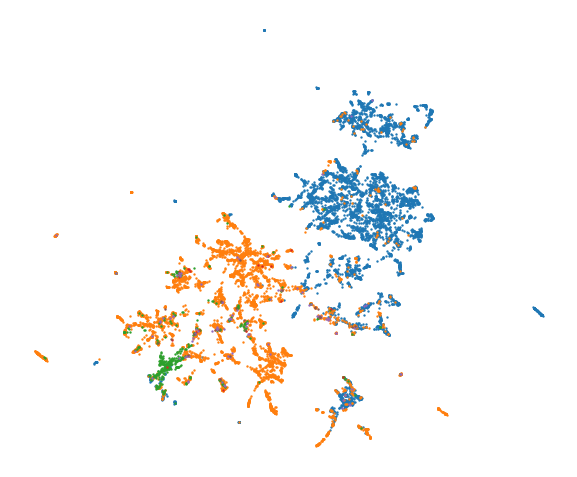

In [ ]:
# UMAP
# seed 42
# reducer = umap.UMAP(random_state=42)
# train_umap_g = reducer.fit_transform(g_feats.cpu().detach().numpy())

plt.figure(figsize=(6,5))
# font size
plt.rcParams.update({'font.size': 14})

for crys in test_df['oxide type'].unique():
    # get indices of the oxide type in numpy array

    indices = np.where(test_df['oxide type'] == crys)[0]
    plt.scatter(train_umap_g[indices,0], train_umap_g[indices,1], s=0.5, label=crys)
# colorbar label
# plt.colorbar().set_label('Power')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# invisible axis
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# remove ticks
plt.xticks([])
plt.yticks([])
# flatten legend
# legend의 항목들을 수평으로 작성
# plt.legend(ncol=4, loc='upper center')
# plt.legend()
plt.tight_layout()
# plt.savefig(f'umap_g_oxide.png', transparent=True, dpi=300)

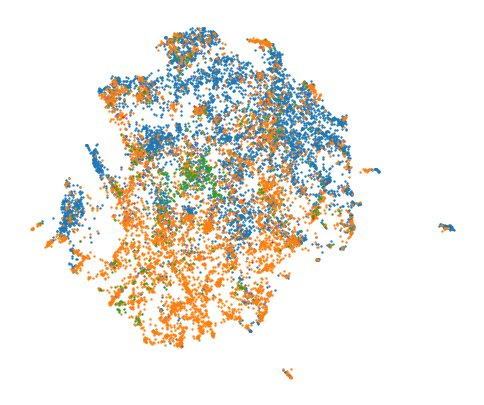

In [ ]:
# UMAP
# seed 42
reducer = umap.UMAP(random_state=42)
train_umap_t = reducer.fit_transform(t_feats.cpu().detach().numpy())

plt.figure(figsize=(6,5))
# font size
plt.rcParams.update({'font.size': 14})

for crys in test_df['oxide type'].unique():
    # get indices of the oxide type in numpy array

    indices = np.where(test_df['oxide type'] == crys)[0]
    plt.scatter(train_umap_t[indices,0], train_umap_t[indices,1], s=0.5, label=crys)
# colorbar label
# plt.colorbar().set_label('Power')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# invisible axis
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# remove ticks
plt.xticks([])
plt.yticks([])
# flatten legend
# legend의 항목들을 수평으로 작성
# plt.legend(ncol=4, loc='upper center')
# legend outside of plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.savefig(os.path.join(directory, 'embeddings', f'tsne_{action_seed}.png'))
# plt.savefig(f'umap_t_oxide.png', transparent=True, dpi=300)

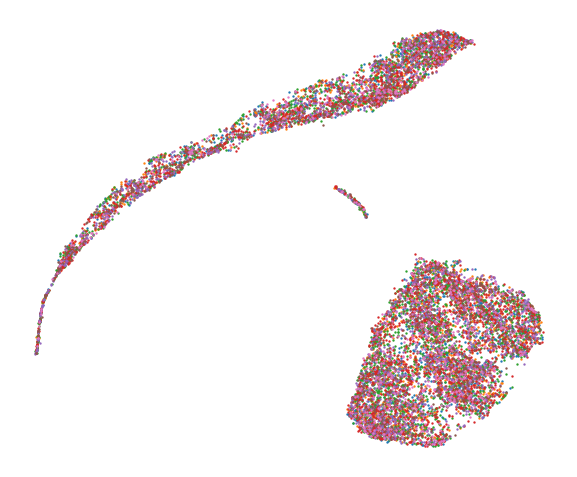

In [35]:
# UMAP
# seed 42
# reducer = umap.UMAP(random_state=42)
# train_umap_to = reducer.fit_transform(t_feats_origin.cpu().detach().numpy())

plt.figure(figsize=(6,5))
# font size
plt.rcParams.update({'font.size': 14})

for crys in test_df['crystal system'].unique():
    # get indices of the crystal system in numpy array

    indices = np.where(test_df['crystal system'] == crys)[0]
    plt.scatter(train_umap_to[indices,0], train_umap_to[indices,1], s=0.5, label=crys)
# colorbar label
# plt.colorbar().set_label('Power')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# invisible axis
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# remove ticks
plt.xticks([])
plt.yticks([])
# flatten legend
# legend의 항목들을 수평으로 작성
# plt.legend(ncol=4, loc='upper center')
# plt.legend()
plt.tight_layout()
plt.savefig(f'umap_scibert_crys.png', transparent=True, dpi=300)